In [2]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [6]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / '../data'

In [7]:
WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA / 'four_sessions.csv'
CLICK_RATE_CSV = DATA / 'click_rates.csv'
IMANISHI_CSV = DATA / 'imanishi_data.csv'

In [28]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times['Time'] = session_times['Time'] * 100

Text(0.5, 0.98, '')

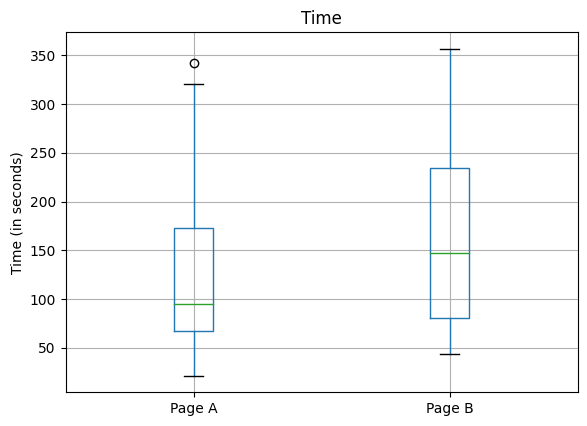

In [29]:
ax = session_times.boxplot(by='Page', column='Time')

ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

In [53]:
time_mean = session_times.groupby('Page').mean()
time_mean.loc['Page B'] - time_mean.loc['Page A']

mean_a = time_mean.loc['Page A'].values[0]
mean_b = time_mean.loc['Page B'].values[0]
mean_b - mean_a

35.66666666666667

In [31]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

In [44]:
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]

perm_diff = perm_fun(session_times['Time'], nA, nB)
print(perm_diff)

32.923809523809524


In [57]:
plt.rcParams['font.family'] = 'AppleGothic'

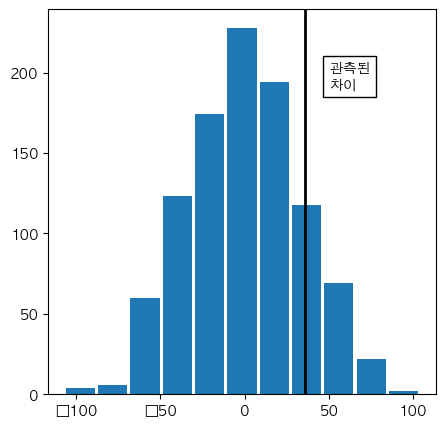

In [60]:
perm_diffs = [perm_fun(session_times['Time'], nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='k', lw=2)
ax.text(50, 190, '관측된\n차이', bbox={'facecolor':'white'})
plt.show()

In [68]:
from scipy import stats

survivors = np.array([[200, 23539], [182, 22406]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value \t {p_value / 2:.4f}')

p-value 	 0.3498


In [75]:
res = stats.ttest_ind(session_times[session_times['Page']=='Page A']['Time'],
                      session_times[session_times['Page']=='Page B']['Time'],
                      equal_var=False)
print(f'p \t{res.pvalue / 2:.4f}')

p 	0.1408


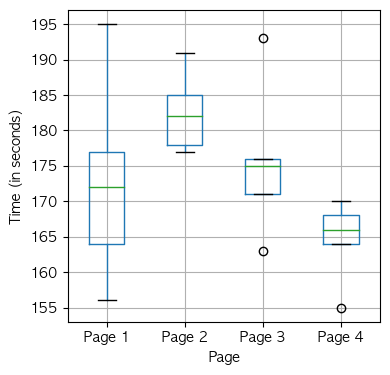

In [78]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [79]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


In [80]:
# Table 3-4
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [82]:
# Table 3-5
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [83]:
# Resampling approach
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4740


In [87]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size = effect_size,
                              alpha=0.05, power=0.6, alternative='larger')

print(result)

67955.62229821966


In [88]:
effect_size

0.01029785095103608

In [89]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

ModuleNotFoundError: No module named 'pygam'

In [91]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / '../data'

In [92]:
LUNG_CSV = DATA / 'LungDisease.csv'
HOUSE_CSV = DATA / 'house_sales.csv'